In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model
import matplotlib.ticker as ticker

In [ ]:
# Functions

def line(x, m, b):
    return x * m + b

def tlm(s, r_s, N, w, L, r_c):
    return ((r_s * s) / (2 * N * (w + L + s) - L - s)) + (2 * r_c)

def tlm2(s, r_s, N, w, L, l_t):
    return (r_s / (2 * N * (w + L + s) - L - s)) * (s + 2 * l_t)

def w_contact(s, N, w, L):
    return (2 * N * (w + L + s)) - L - s

In [ ]:
# Models

line_mod = Model(line)
line_params = line_mod.make_params(m = 1, b = 1)

# Considering L_t to get \rho_c Contact Resistivity
tlm_mod2 = Model(tlm2)
tlm2_params = tlm_mod2.make_params()
tlm2_params['r_s'].set(value = 1e6)
tlm2_params['N'].set(value = 60, vary = False)
tlm2_params['w'].set(value = 5e-4, vary = False)
tlm2_params['L'].set(value = 3200e-4, vary = False)
tlm2_params['l_t'].set(value = 1e-5, min = 0)

In [ ]:
# Settings

col = ['Potential (V)', 'Current (A)', 'Time (s)']
col2 = ['Structure', 'Spacing (cm)', 'Resistance ($\Omega$)']
idea2 = {'P01': 2e-4,
         'P02': 5e-4,
         'P03': 10e-4,
         'P04' : 20e-4
         }

formatter = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x / 1e6))
formatter_1 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e4))

sns.set_palette('BuPu_r')

In [55]:
# Function to process data

def C_R(path, thickness, sample):
    
    files = [os.path.join(path, i) for i in os.listdir(path)]
    iv_val = pd.DataFrame(columns = col2)
    iv_df = pd.DataFrame()
    n = 0
    for i in files:
        directory, filename = os.path.split(i)
        df = pd.read_csv(i, sep = ';', skiprows = 1, names = col)
        df['Device'] = filename[:-4]
        line_fit = line_mod.fit(df[col[1]], line_params, x = df[col[0]])
        resistance = 1 / line_fit.values['m']
        
        for j in idea2.keys():
            if j in filename:
                iv_val.loc[n] = (j, idea2[j], resistance)
        iv_df = pd.concat([iv_df, df], ignore_index = True)
        
        n += 1

    iv_val['Sample'] = sample
    # print(iv_val)

    width_ = (w_contact(iv_val[col2[1]], 60, 5e-4, 3200e-4))
    width_avg = width_.mean()

    all_avg = pd.DataFrame()
    u_s = iv_val.Structure.unique()
    df_dict = {i : pd.DataFrame() for i in u_s}
    
    for key in df_dict.keys():
        df_dict[key] = iv_val[:][iv_val.Structure == key]
        
    for key, df in df_dict.items():
        mean_ = df.mean(numeric_only = True).reset_index().transpose()
        mean_.columns = mean_.iloc[0]
        mean_ = mean_[1:].reset_index(drop=True)
        all_avg = pd.concat([all_avg, mean_], ignore_index = True)
    
    
    tlm_fit2 = tlm_mod2.fit(all_avg[col2[2]], tlm2_params, s = all_avg[col2[1]])   
    # using the average for the fit. Same values, lower numerical error 
    # tlm_fit2 = tlm_mod2.fit(iv_val[col2[2]], tlm2_params, s = iv_val[col2[1]])
    
    # print(tlm_fit2.fit_report())
    rc = tlm_mod2.eval(tlm_fit2.params, s = 0) / 2
    lt = tlm_fit2.values['l_t']
    p_c = rc * lt * width_avg #Contact resistiviy ohm * cm^2
    sigma = (1 / tlm_fit2.values['r_s'] ) / (thickness * 1e-7 * width_avg)
    r_s = tlm_fit2.values['r_s']

    print('Contact Resistivity = ' + str(p_c) + ' Ohm cm2')
    print('LMO conductivity = ' + str(sigma) + ' S/cm')
    
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = 200) #    1, 2, figsize = (15,5),
    
    cross_zero = np.array([-1, 0, 20]) * 1e-4
    y_zero = tlm_mod2.eval(tlm_fit2.params, s = cross_zero)
    
    sns.lineplot(data = iv_val, x = col2[1], y = col2[2], marker='o', markersize = 8, errorbar='sd',err_style='bars', linestyle='')
    sns.lineplot(x = cross_zero, y = y_zero)
    
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Horizontal zero line
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Vertical zero line
    
    ax[1].set_xlabel('Spacing ($\mu$m)')
    ax[1].set_ylabel('Resistance ($\Omega$)')
    # ax[1].yaxis.set_major_formatter(formatter)
    ax[1].xaxis.set_major_formatter(formatter_1)
    #
    sns.scatterplot(data = iv_val, x = col2[1], y = col2[2], ax = ax[0])
    
    fit_vals = {'Sheet Resistance' : r_s,
                'Contact Resistance' : rc,
                'Transfer Lenght' : lt,
                'Contact Resistivity' : p_c,
                'Conductivity' : sigma,
                'Sample' : sample}
    
    return iv_val, tlm_fit2, fit_vals, iv_df

Contact Resistivity = 223.39672851086019 Ohm cm2
LMO conductivity = 9.079742489253858e-09 S/cm


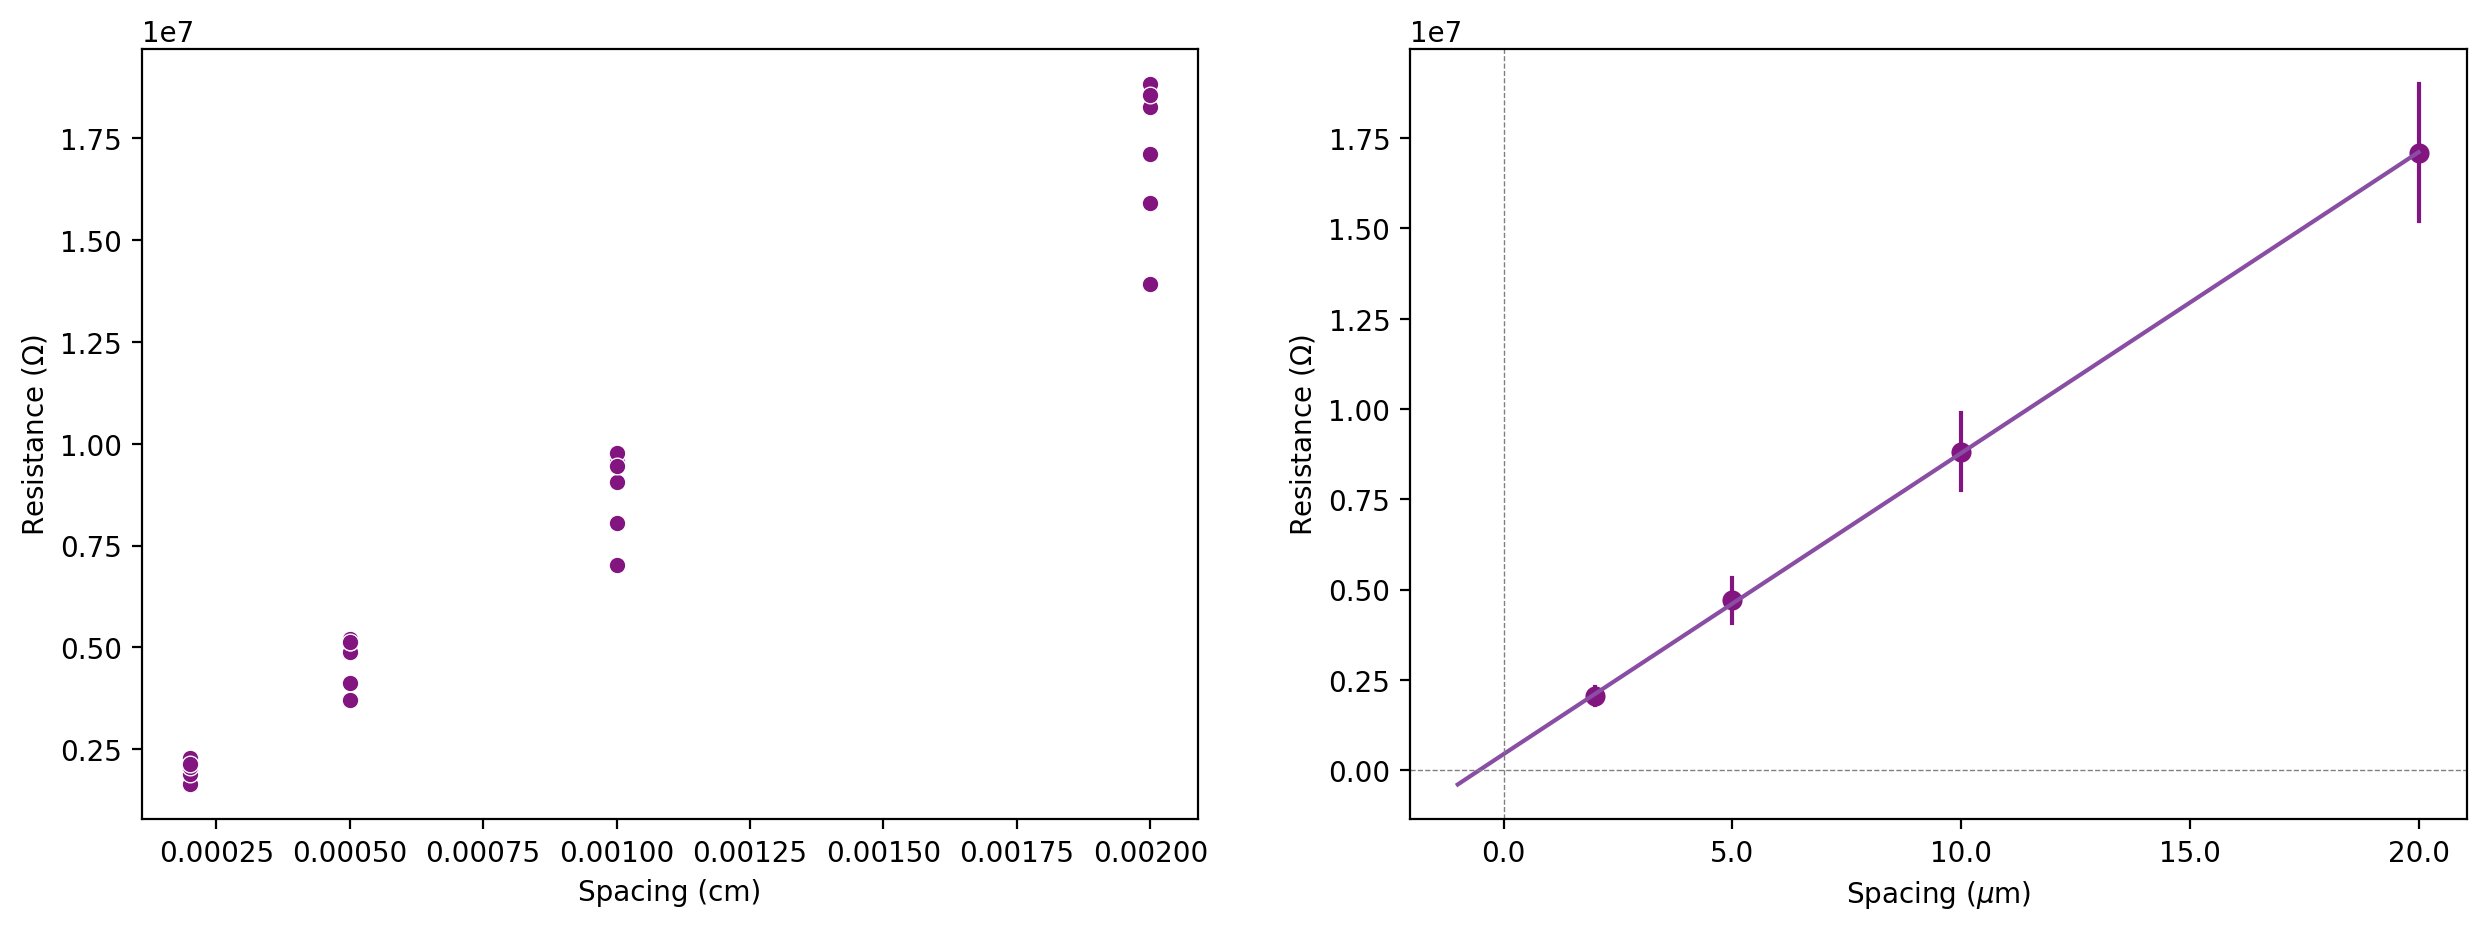

In [56]:
# TI2_01
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO_Pt'
sample = 'LMO/Pt'
TI2_01, TI2_01_fit, TI2_01_fit_vals, TI2_01_iv_curves= C_R(path, 90,  sample)


Contact Resistivity = 2135.9610582080472 Ohm cm2
LMO conductivity = 3.473935362634216e-08 S/cm


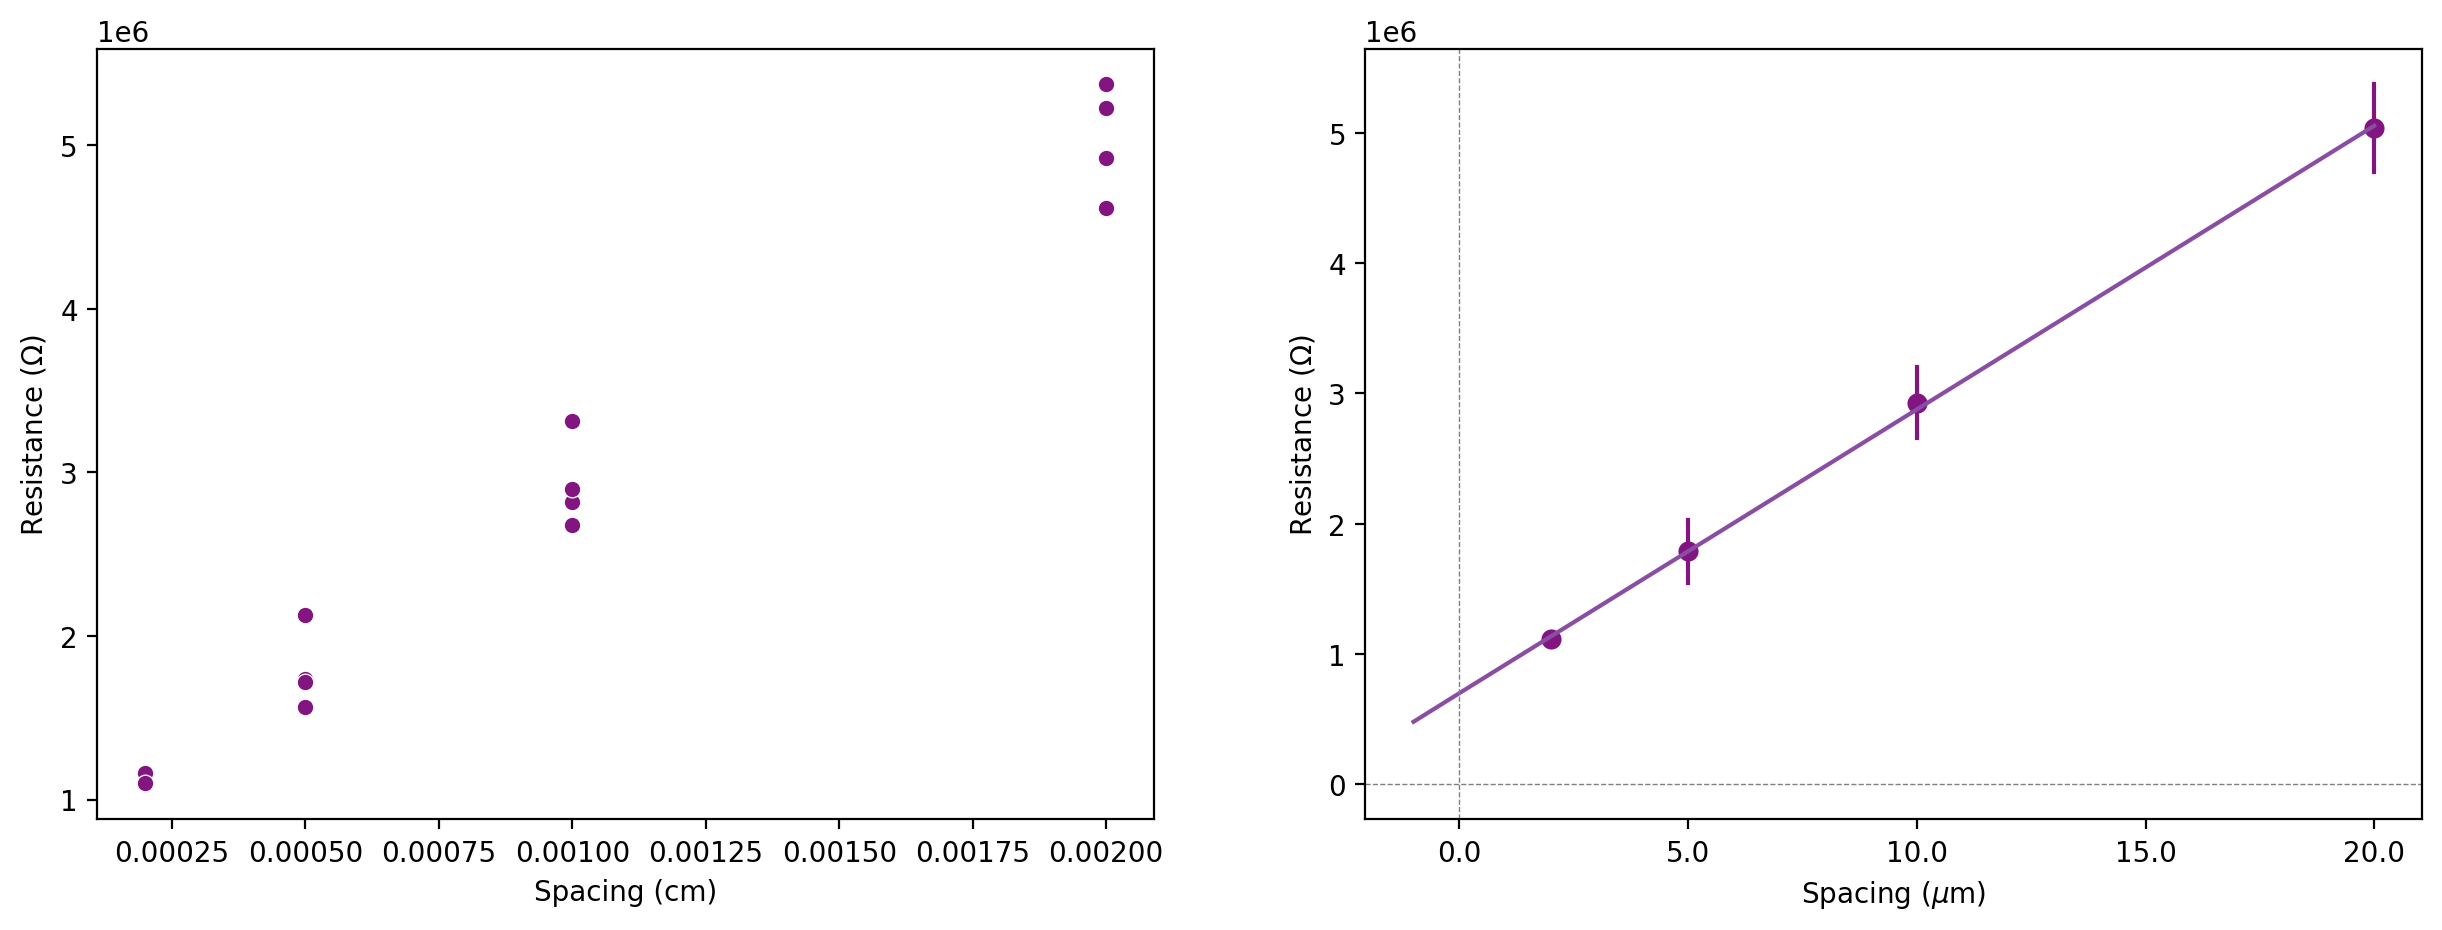

In [57]:
# LMO/C/Pt
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO_C_Pt'
sample = 'LMO 90nm/C 65nm/Pt 100nm'
lmo_c_pt, lmo_c_pt_fit, lmo_c_pt_fit_vals, lmo_c_pt_iv_curves = C_R(path, 90, sample)

Contact Resistivity = 2.9193733396085153 Ohm cm2
LMO conductivity = 1.7986326193064155e-06
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 76
    # data points      = 4
    # variables        = 2
    chi-square         = 184227.867
    reduced chi-square = 92113.9333
    Akaike info crit   = 46.9505373
    Bayesian info crit = 45.7231260
    R-squared          = 0.99956921
[[Variables]]
    r_s:  5.8138e+08 +/- 8506122.20 (1.46%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  7.0758e-05 +/- 9.2452e-06 (13.07%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.842


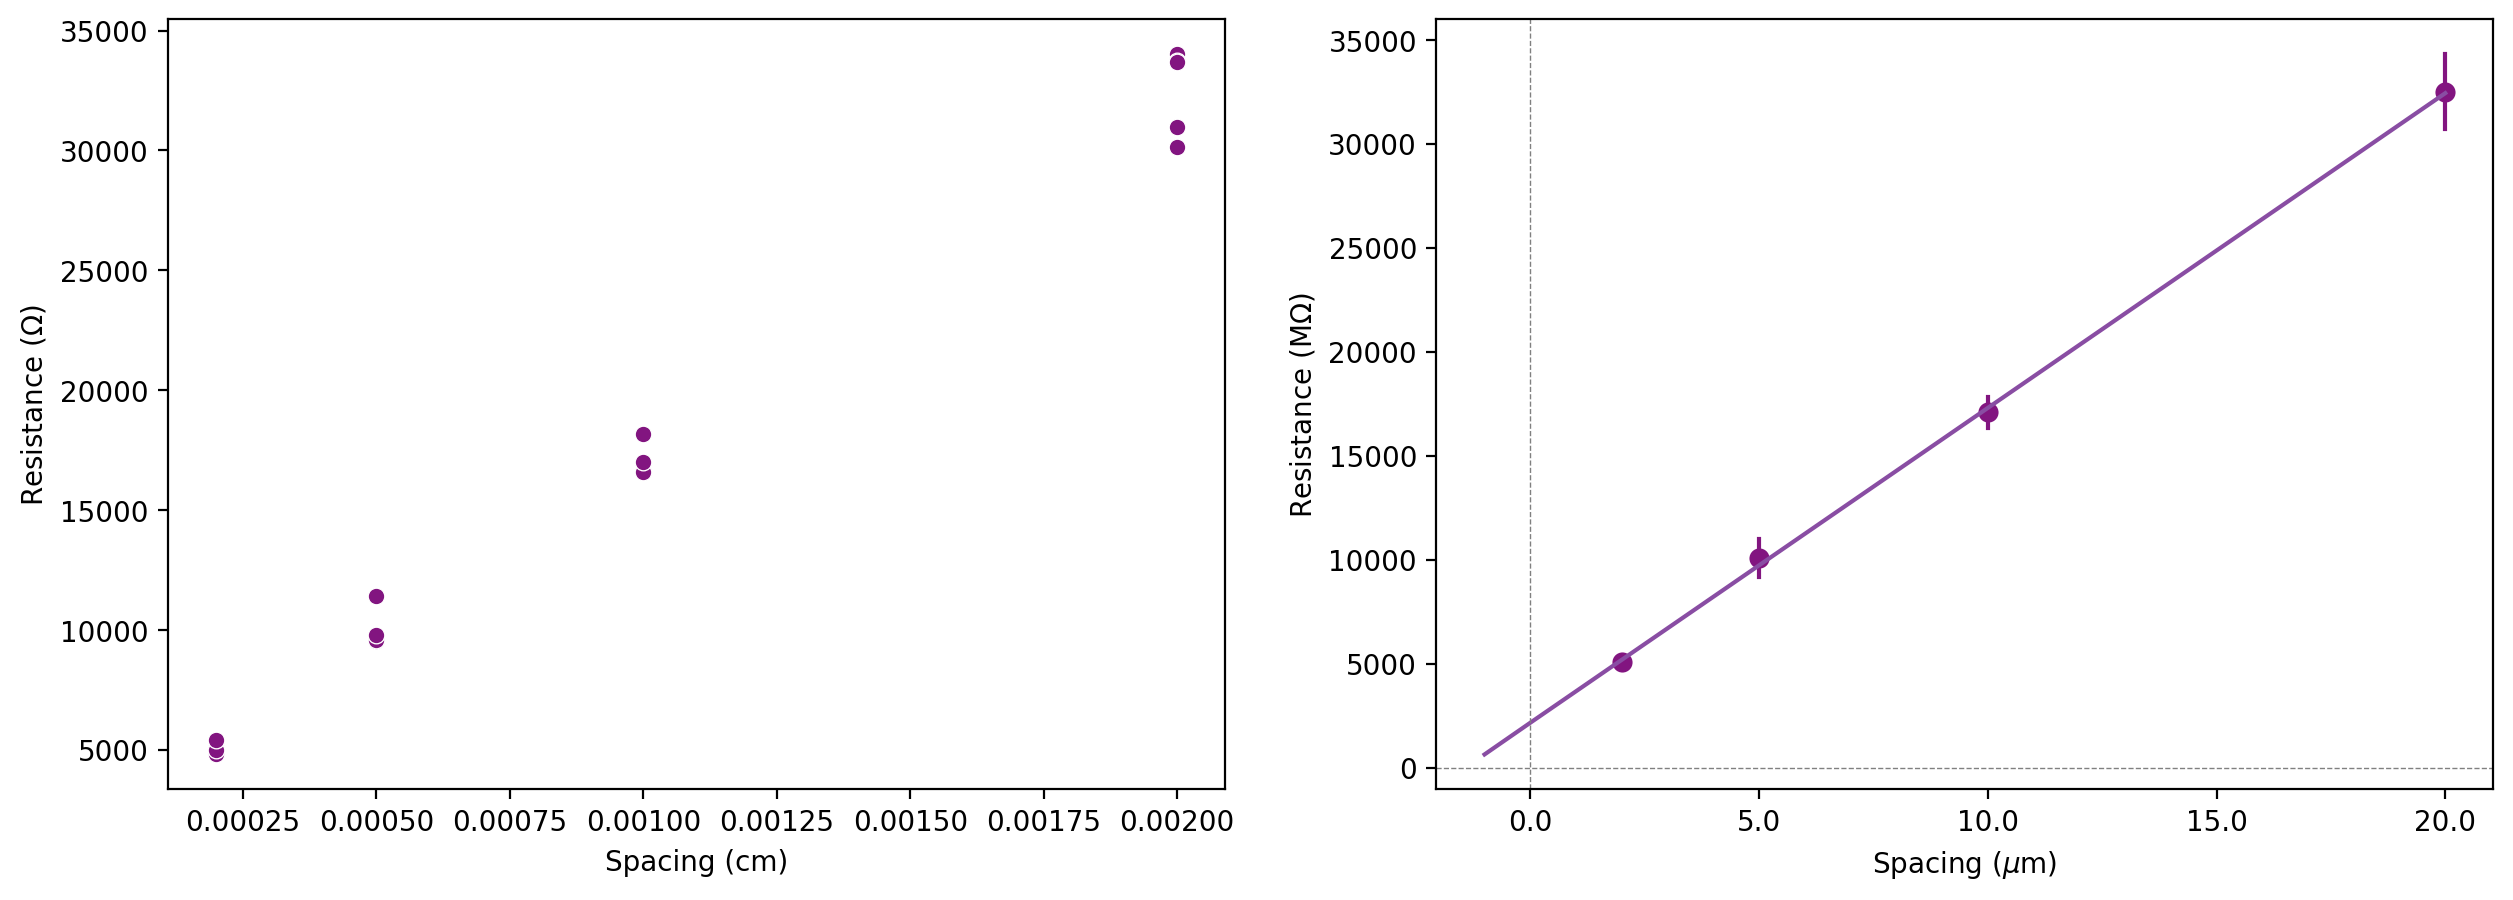

In [53]:
# TI2_03 LMO 8h
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO8h_Pt'
sample = 'LMO 250nm/Pt 100nm'
lmo8h_pt, lmo8h_pt_fit, lmo8h_pt_fit_vals, lmo8h_pt_iv_curves = C_R(path, 250, sample)
print(lmo8h_pt_fit.fit_report())

,Sheet Resistance,Contact Resistance,Transfer Lenght,Contact Resistivity,Conductivity,Sample
0,3.199276e+11,221338.900618,0.000026,223.396729,9.079742e-09,LMO/Pt
1,8.361871e+10,349898.361197,0.000160,2135.961058,3.473935e-08,LMO 90nm/C 65nm/Pt 100nm
2,5.813785e+08,1078.585742,0.000071,2.919373,1.798633e-06,LMO 250nm/Pt 100nm


Text(0, 0.5, 'Resistance (M$\\Omega$)')

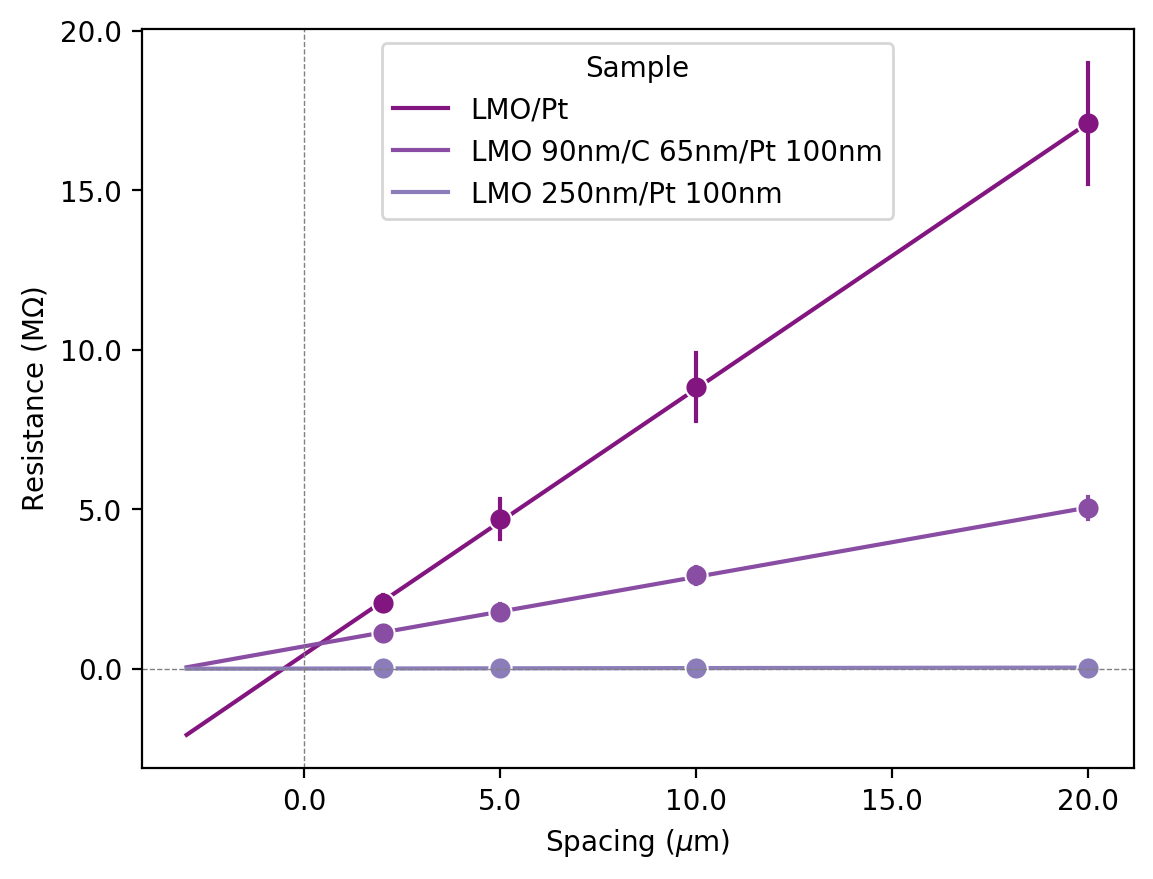

In [58]:
# Compare
cross_zero = np.array([-3, 0, 20]) * 1e-4
    # y_zero = tlm_mod2.eval(tlm_fit2.params, s = cross_zero)

vals = pd.concat([TI2_01, lmo_c_pt, lmo8h_pt], ignore_index = True)
fit = [TI2_01_fit, lmo_c_pt_fit, lmo8h_pt_fit]
fit_val = pd.concat([pd.DataFrame(TI2_01_fit_vals, index = [0]), pd.DataFrame(lmo_c_pt_fit_vals, index = [0]), pd.DataFrame(lmo8h_pt_fit_vals, index = [0])], ignore_index=True)
display(fit_val)


fig, ax = plt.subplots(dpi = 200)

for i in fit:
    y_zero = tlm_mod2.eval(i.params, s = cross_zero)
    sns.lineplot(x = cross_zero, y = y_zero)

# 
    

sns.lineplot(data = vals, x = col2[1], y = col2[2], marker='o', markersize = 8, errorbar='sd',err_style='bars', linestyle='', hue = 'Sample')

plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Horizontal zero line
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Vertical zero line

ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter_1)

ax.set_xlabel('Spacing ($\mu$m)')
ax.set_ylabel('Resistance (M$\Omega$)')
# TI2_01_fit.params
# vals